<a href="https://colab.research.google.com/github/mingjian-shi/CSC207Simulator/blob/master/image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

In [5]:
zip_file_path = '/content/drive/MyDrive/images.zip'
target_folder = '/content/unformatted image'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to the target folder
    zip_ref.extractall(target_folder)

In [10]:
root_dir = '/content/unformatted image'

# Iterate over each folder in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    if folder_name == '__MACOSX':
      continue
    # Skip if the item in the root directory is not a folder
    if not os.path.isdir(folder_path):
        continue
    
 # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
         if not filename.endswith('.png'):
        # Create the new filename by replacing the extension with '.png'
          new_filename = os.path.splitext(filename)[0] + '.png'
        
        # Rename the file
          os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))

In [ ]:
model = tf.keras.applications.MobileNetV2(weights='imagenet')

# Print the model summary
model.summary()

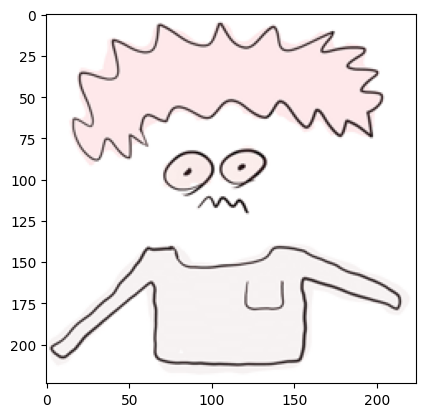

Shape of x: (1, 224, 224, 3)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

def load_image(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))  # Adjust the size as per your model's input shape
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Load the image and retrieve the image and input tensor
path = "/content/unformatted image/0x2e541cec5cb41e7678ac3c8e91acb3fc1db0da07/0x2e541cec5cb41e7678ac3c8e91acb3fc1db0da07_1.png"
img, x = load_image(path)

# Display the image
plt.imshow(img)
plt.show()

# Print the shape of the input tensor
print("Shape of x:", x.shape)

In [17]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

35363/35363 [==============================] - 0s 0us/step
predicted jigsaw_puzzle with probability 0.064
predicted binder with probability 0.042
predicted web_site with probability 0.030
predicted fire_screen with probability 0.028
predicted corkscrew with probability 0.026


In [ ]:

# Create the feature extractor model
feat_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer("global_average_pooling2d").output)

# Print the summary of the feature extractor
feat_extractor.summary()

1/1 [==============================] - 0s 35ms/step
(1, 1280)


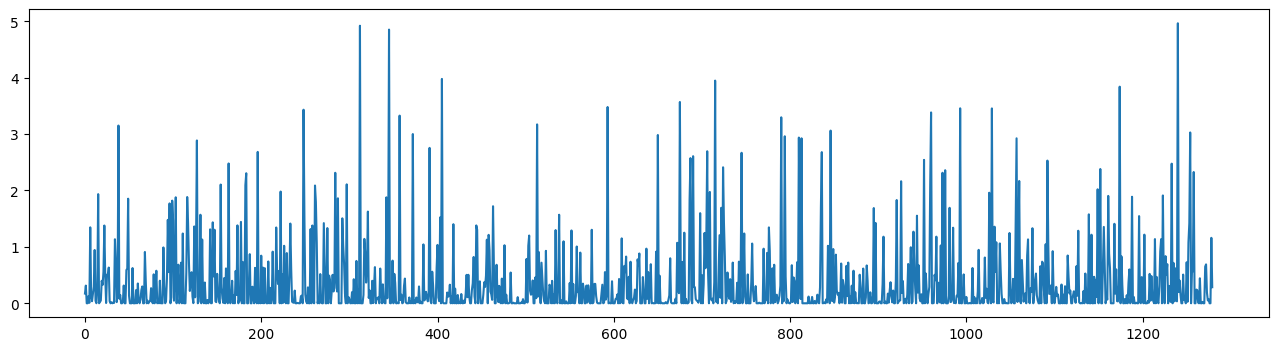

In [25]:
path = "/content/unformatted image/0x2e541cec5cb41e7678ac3c8e91acb3fc1db0da07/0x2e541cec5cb41e7678ac3c8e91acb3fc1db0da07_1.png"
img, x = load_image(path)
feat = feat_extractor.predict(x)
print(feat.shape)
plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [27]:
import imgaug.augmenters as iaa
import glob
# Path to the folder containing the images
folder_path = '/content/unformatted image'

# List all image file paths in the folder
image_paths = glob.glob(os.path.join(folder_path, '*.png'))  # Adjust the file extension if needed

# Define the augmentation pipeline
augmenter = iaa.Sequential([
    iaa.Flipud(),  # Flip vertically
    iaa.Affine(rotate=(-30, 30)),  # Rotate by a random angle
    iaa.Affine(translate_percent={"x": (-0.2, 0.2)}, mode='symmetric'),  # Perform left and right movement
    iaa.Affine(translate_percent={"y": (-0.2, 0.2)}, mode='symmetric'),  # Perform top and bottom movement
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Apply Gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.1 * 255))  # Add Gaussian noise
])

# Apply augmentation to each image
for image_path in image_paths:
    # Load and preprocess the image
    image = plt.imread(image_path)

    # Augment the image
    augmented_images = augmenter.augment_images([image])

    # Save the augmented images with new file names
    base_name = os.path.basename(image_path)
    file_name, file_ext = os.path.splitext(base_name)
    for i, augmented_image in enumerate(augmented_images):
        new_file_name = f'{file_name}_augmented_{i}{file_ext}'
        new_file_path = os.path.join(folder_path, new_file_name)
        plt.imsave(new_file_path, augmented_image)

    print(f"Augmented images saved for: {image_path}")

In [21]:
images_path = '/content/unformatted image/0x2e541cec5cb41e7678ac3c8e91acb3fc1db0da07'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 6919 images to analyze


In [ ]:
import time

tic = time.perf_counter()

features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.perf_counter()
        elap = toc - tic
        print("Analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images), elap))
        tic = time.perf_counter()
    img, x = load_image(image_path)
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('Finished extracting features for %d images' % len(images))

In [ ]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_features = pca.transform(features)

In [ ]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [ ]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [ ]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

In [ ]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


In [ ]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")